In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from langsmith.schemas import DatasetShareSchema
from numpy.testing.print_coercion_tables import print_cancast_table
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.impute import KNNImputer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import linkage, dendrogram
from math import ceil
import re

from sympy import reduced
from torch.export import export_for_training
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV

from skopt import BayesSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import joblib

In [25]:
%config InlineBackend.figure_format = 'retina'
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
pd.options.display.max_colwidth = 100
pd.options.display.max_columns = 50

In [26]:
data = pd.read_pickle('../data/cleaned_data_with_clusters.pkl')

## 4. Model Training
### 4.1 Normalisation and prepping of Dataset

In [27]:
def binarize_columns(df, columns):
    mlb_dict = {}
    for column_name in columns:

        if not all(isinstance(x, list) for x in df[column_name]):
            raise ValueError(f"The column '{column_name}' must contain lists of labels.")

        mlb = MultiLabelBinarizer()
        encoded_data = mlb.fit_transform(df[column_name])
        encoded_df = pd.DataFrame(encoded_data, columns=[f"{column_name}_{cls}" for cls in mlb.classes_],
                                  index=df.index)
        df = pd.concat([df.copy(), encoded_df], axis=1)
        mlb_dict[column_name] = mlb

    return df, mlb_dict


def scale_columns(df, columns):
    scaler = StandardScaler()
    df[columns] = scaler.fit_transform(df[columns])

    return df, scaler


def cat_code(df, columns):
    for col in columns:
        df[col] = df[col].astype('category').cat.codes

    return df


def prep_df(df: pd.DataFrame):
    encoded_df = df.copy()

    # Encoding Nominal Features
    encoded_df, mlb_dict = binarize_columns(encoded_df, ['Domains', 'Clusters'])

    # Encoding Ordinal Features
    encoded_df = cat_code(encoded_df, ['Year Published Bins', 'Play Time Bins'])

    # Scaling
    encoded_df, scaler = scale_columns(encoded_df,
                                       ['Min Players', 'Max Players', 'Min Age'])

    # Dropping now-defunct columns
    encoded_df = encoded_df.drop(columns=['Name', 'Mechanics', 'Domains', 'Clusters'])

    return encoded_df, mlb_dict, scaler

In [28]:
encoded, mlbs, scaler = prep_df(data)
encoded.head()

,Year Published Bins,Min Players,Max Players,Play Time Bins,Min Age,Rating Average,Complexity Average,Popularity Score,Domains_Abstract Games,Domains_Children's Games,Domains_Customizable Games,Domains_Family Games,Domains_Party Games,Domains_Strategy Games,Domains_Thematic Games,Domains_Wargames,Clusters_0,Clusters_1,Clusters_2,Clusters_3,Clusters_4,Clusters_5,Clusters_6,Clusters_7
0,6,-1.502836,-0.176112,5,1.394576,8.79244,3.8604,10.0,0,0,0,0,0,1,1,0,0,0,1,1,1,1,1,0
1,6,-0.037141,-0.176112,3,1.024598,8.61278,2.8405,10.0,0,0,0,0,0,1,1,0,0,0,1,1,1,1,0,0
2,6,-0.037141,-0.176112,5,1.394576,8.66337,3.9129,10.0,0,0,0,0,0,1,0,0,0,1,1,0,1,1,1,0
3,6,-1.502836,-0.061961,5,0.654621,8.43254,3.2406,10.0,0,0,0,0,0,1,0,0,0,1,1,0,1,1,1,0
5,6,-1.502836,-0.176112,5,1.394576,8.87363,3.5472,10.0,0,0,0,0,0,1,1,0,0,1,1,1,1,1,1,0


### 4.2 Dimensionality Reduction
#### 4.2.1 PCA

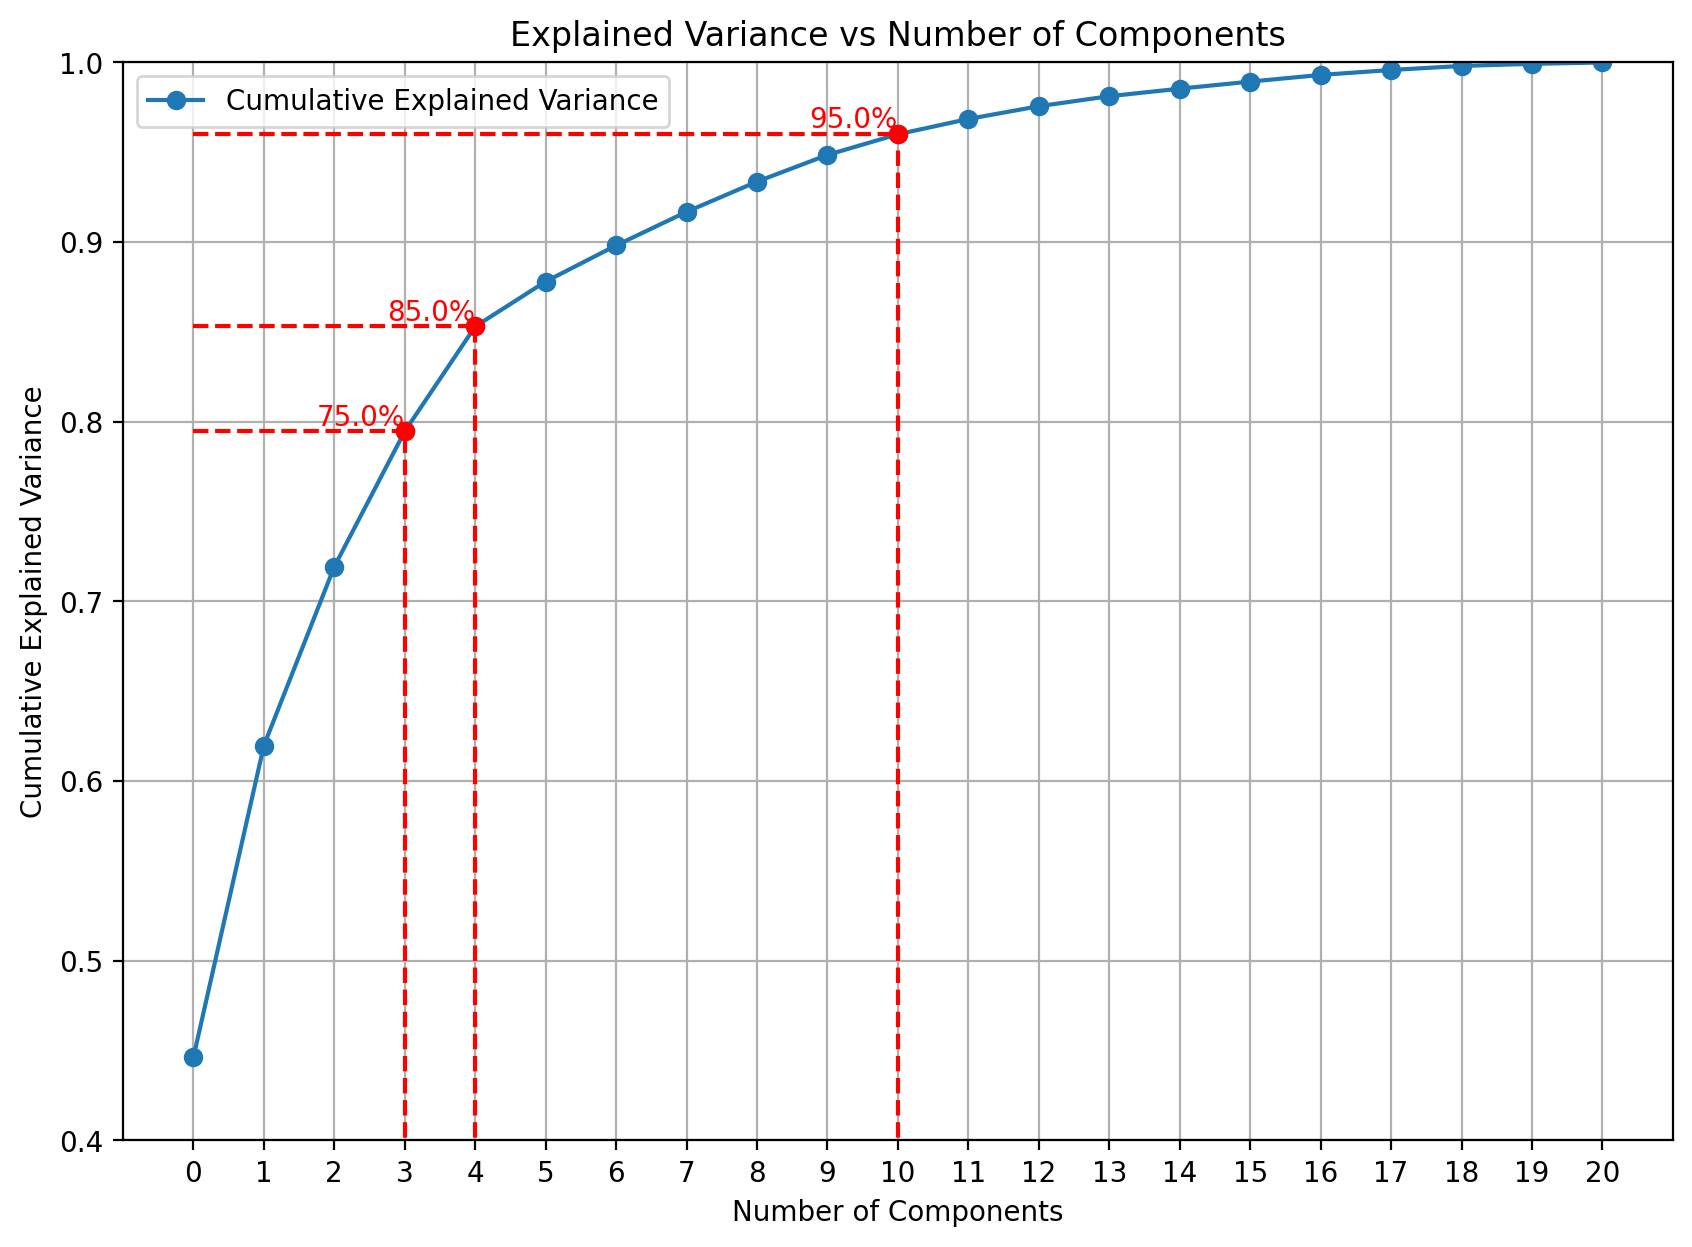

In [29]:
from sklearn.decomposition import PCA

target_names = ['Rating Average', 'Complexity Average', 'Popularity Score']
encoded_features = encoded.copy().drop(columns=target_names)
targets = encoded.copy()[target_names]

# Apply PCA
pca = PCA()
_ = pca.fit(encoded_features)

# Get the explained variance ratio and cumulative explained variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plot the cumulative explained variance
_ = plt.figure(figsize=(10, 7))
_ = plt.plot(cumulative_variance, marker='o', label='Cumulative Explained Variance')

# Define the thresholds for 75%, 85%, and 95% variance
thresholds = [0.75, 0.85, 0.95]

for threshold in thresholds:
    # Find the number of components required to explain at least 'threshold' variance
    component_index = np.argmax(cumulative_variance >= threshold)

    # Mark the point with a red dot
    _ = plt.plot(component_index, cumulative_variance[component_index], 'ro')  # Red dot

    # Draw striped lines from the red dot to the axes
    _ = plt.plot([component_index, component_index], [0,cumulative_variance[component_index]], 'r--')  # Vertical line
    
    _ = plt.plot([0, component_index], [cumulative_variance[component_index], cumulative_variance[component_index]], 'r--')  # Horizontal line

    # Annotate the point
    _ = plt.text(component_index, cumulative_variance[component_index], f'{threshold*100}%',
             color='r', ha='right', va='bottom')

# Labeling and displaying the plot
_ = plt.xticks(np.arange(0, len(cumulative_variance), 1))
_ = plt.ylim(0.4, 1)
_ = plt.xlabel('Number of Components')
_ = plt.ylabel('Cumulative Explained Variance')
_ = plt.title('Explained Variance vs Number of Components')
plt.grid(True)
_ = plt.legend()
plt.show()


In [30]:
encoded_features.head(5)

,Year Published Bins,Min Players,Max Players,Play Time Bins,Min Age,Domains_Abstract Games,Domains_Children's Games,Domains_Customizable Games,Domains_Family Games,Domains_Party Games,Domains_Strategy Games,Domains_Thematic Games,Domains_Wargames,Clusters_0,Clusters_1,Clusters_2,Clusters_3,Clusters_4,Clusters_5,Clusters_6,Clusters_7
0,6,-1.502836,-0.176112,5,1.394576,0,0,0,0,0,1,1,0,0,0,1,1,1,1,1,0
1,6,-0.037141,-0.176112,3,1.024598,0,0,0,0,0,1,1,0,0,0,1,1,1,1,0,0
2,6,-0.037141,-0.176112,5,1.394576,0,0,0,0,0,1,0,0,0,1,1,0,1,1,1,0
3,6,-1.502836,-0.061961,5,0.654621,0,0,0,0,0,1,0,0,0,1,1,0,1,1,1,0
5,6,-1.502836,-0.176112,5,1.394576,0,0,0,0,0,1,1,0,0,1,1,1,1,1,1,0


In [31]:
datasets = {
    'original': encoded_features,
    
    # Volgende Datasets zijna getest geweest, maar hadden geen positieve invloed op de RMSE, MAE of R2 score
    # 'pca_95': PCA(n_components=0.95).fit_transform(encoded_features),
    # 'pca_90': PCA(n_components=0.90).fit_transform(encoded_features),
    # 'ANOVA_avg_rating_8': SelectKBest(f_classif, k=8).fit_transform(encoded_features, targets['Rating Average'] ),
    # 'ANOVA_avg_rating_10': SelectKBest(f_classif, k=10).fit_transform(encoded_features, targets['Rating Average'] ),
    # 'ANOVA_avg_rating_12': SelectKBest(f_classif, k=12).fit_transform(encoded_features, targets['Rating Average'] ),
    # 'ANOVA_complexity_rating_12': SelectKBest(f_classif, k=12).fit_transform(encoded_features, targets['Complexity Average'] ),
    # 'ANOVA_popularity_12': SelectKBest(f_classif, k=12).fit_transform(encoded_features, targets['Popularity Score'] ),
    # 'without_domains': encoded_features.drop(columns=[col for col in encoded_features.columns if col.startswith('Domains')]),
}

Uit de resultaten hieronder blijft dat dimensionality reduction geen positieve invloed op de resultaten heeft.

### 4.3 Model Training and Evaluation

In [32]:
def train_and_evaluate_models(datasets, targets, test_train_ratio, models):
    results = []
    
    for dataset_name, dataset in datasets.items():
        print(f"Processing Dataset: {dataset_name}")
        for target in targets.columns:
    
            print(f"\tProcessing target column: {target}")
    
            X = dataset
            y = targets[target]
    
            # Splitting dataset into train and test sets
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_train_ratio, random_state=42)
    
            for model_name, model in models.items():
                print(f"\t\tTraining model: {model_name}")
                model.fit(X_train, y_train)
    
                # Making predictions
                y_pred = model.predict(X_test)
    
                # Calculating evaluation metrics
                rmse = root_mean_squared_error(y_test, y_pred)
                mae = mean_absolute_error(y_test, y_pred)
                r2 = r2_score(y_test, y_pred)
    
                # Appending metrics
                metrics = {
                    'Dataset': dataset_name,
                    'Target': target, 
                    'Model Name': model_name, 
                    'Model': model, 
                    'RMSE': rmse,
                    'MAE': mae, 
                    'R2': r2}
    
                # Save results for the target column
                results.append(metrics)

    return results


# Define models
model_dict = {
    'Support Vector Regressor': SVR(),
    'Linear Regression': LinearRegression(),
    'GradientBoostingRegressor': GradientBoostingRegressor(random_state=42),
    
    # Volgende modellen underperformden
    # 'Random Forest': RandomForestRegressor(random_state=42),
    # 'KNeighbors Regressor': KNeighborsRegressor(),
    # 'Decision Tree': DecisionTreeRegressor(random_state=42),
    # 'AdaBoostRegressor': AdaBoostRegressor(random_state=42),
}

# Run method
evaluation_results = train_and_evaluate_models(datasets, targets, 0.2, model_dict)


Processing Dataset: original
	Processing target column: Rating Average
		Training model: Support Vector Regressor
		Training model: Linear Regression
		Training model: GradientBoostingRegressor
	Processing target column: Complexity Average
		Training model: Support Vector Regressor
		Training model: Linear Regression
		Training model: GradientBoostingRegressor
	Processing target column: Popularity Score
		Training model: Support Vector Regressor
		Training model: Linear Regression
		Training model: GradientBoostingRegressor


In [33]:
def best_dataset_and_model(df):
    """
    Prints the best Dataset and Model Name for each Target based on RMSE, MAE, and R2 metrics.

    Args:
        df (pd.DataFrame): Dataframe containing the columns: Dataset, Target, Model Name, RMSE, MAE, and R2.

    """
    # Validate input dataframe
    required_columns = {'Dataset', 'Target', 'Model Name', 'RMSE', 'MAE', 'R2'}
    if not required_columns.issubset(df.columns):
        raise ValueError(f"DataFrame must contain the following columns: {required_columns}")

    # Group by Target
    grouped = df.groupby('Target')

    # Iterate through each Target group
    for target, group in grouped:
        print(f"\nTarget: {target}")

        # Find the best entries for each metric
        best_rmse = group.loc[group['RMSE'].idxmin()]  # Lower is better for RMSE
        best_mae = group.loc[group['MAE'].idxmin()]    # Lower is better for MAE
        best_r2 = group.loc[group['R2'].idxmax()]      # Higher is better for R2

        # Print the results
        print(f"Best RMSE -> Dataset: {best_rmse['Dataset']}, Model: {best_rmse['Model Name']}, RMSE: {best_rmse['RMSE']:.3}")
        print(f"Best MAE  -> Dataset: {best_mae['Dataset']}, Model: {best_mae['Model Name']}, MAE: {best_mae['MAE']:.3}")
        print(f"Best R2   -> Dataset: {best_r2['Dataset']}, Model: {best_r2['Model Name']}, R2: {best_r2['R2']:.3}")


results = pd.DataFrame(evaluation_results, columns=['Dataset','Target', 'Model Name', 'RMSE', 'MAE', 'R2'])
best_dataset_and_model(results)


Target: Complexity Average
Best RMSE -> Dataset: original, Model: Support Vector Regressor, RMSE: 0.5
Best MAE  -> Dataset: original, Model: Support Vector Regressor, MAE: 0.361
Best R2   -> Dataset: original, Model: Support Vector Regressor, R2: 0.649

Target: Popularity Score
Best RMSE -> Dataset: original, Model: GradientBoostingRegressor, RMSE: 2.1
Best MAE  -> Dataset: original, Model: GradientBoostingRegressor, MAE: 1.72
Best R2   -> Dataset: original, Model: GradientBoostingRegressor, R2: 0.4

Target: Rating Average
Best RMSE -> Dataset: original, Model: GradientBoostingRegressor, RMSE: 0.668
Best MAE  -> Dataset: original, Model: Support Vector Regressor, MAE: 0.507
Best R2   -> Dataset: original, Model: GradientBoostingRegressor, R2: 0.454


### 4.4 Hypertuning

In [34]:
evaluation_results

[{'Dataset': 'original',
  'Target': 'Rating Average',
  'Model Name': 'Support Vector Regressor',
  'Model': SVR(),
  'RMSE': 0.66905882550556,
  'MAE': 0.5074048085287372,
  'R2': 0.4516459398979681},
 {'Dataset': 'original',
  'Target': 'Rating Average',
  'Model Name': 'Linear Regression',
  'Model': LinearRegression(),
  'RMSE': 0.7196601911747952,
  'MAE': 0.5478973306121805,
  'R2': 0.36556458848499174},
 {'Dataset': 'original',
  'Target': 'Rating Average',
  'Model Name': 'GradientBoostingRegressor',
  'Model': GradientBoostingRegressor(random_state=42),
  'RMSE': 0.6676278009473762,
  'MAE': 0.50842295665076,
  'R2': 0.45398913874826785},
 {'Dataset': 'original',
  'Target': 'Complexity Average',
  'Model Name': 'Support Vector Regressor',
  'Model': SVR(),
  'RMSE': 0.49979097942530143,
  'MAE': 0.3606623291027847,
  'R2': 0.6488292024499217},
 {'Dataset': 'original',
  'Target': 'Complexity Average',
  'Model Name': 'Linear Regression',
  'Model': LinearRegression(),
  'RMS

In [35]:
def evaluate_hypertuned_model(original_results, best_model, X_test, y_test):

    # Generate predictions
    y_pred = best_model.predict(X_test)

    # Compute evaluation metrics
    rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))  # Root Mean Squared Error
    mae = mean_absolute_error(y_test, y_pred)       # Mean Absolute Error
    r2 = r2_score(y_test, y_pred)                   # R² Score

    print(f"{original_results['Target']}Evaluation Results:")
    print(f"{"RMSE:":5}{original_results['RMSE']: .3f} --> {rmse:.3f}")
    print(f"{"MAE:":5}{original_results['MAE']: .3f} --> {mae:.3f}")
    print(f"{"R2:":5}{original_results['R2']: .3f} --> {r2:.3f}")

    plt.figure(figsize=(8, 8))
    plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='k', label='Predicted vs Actual')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Optimal')
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f"{original_results['Target']}")
    plt.legend()
    plt.grid(True)
    plt.show()
    

#### 4.4.1 SVR - Complexity Average

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best parameters for SVR: {'C': 3.0, 'epsilon': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}
Complexity AverageEvaluation Results:
RMSE: 0.500 --> 0.492
MAE:  0.361 --> 0.357
R2:   0.649 --> 0.649


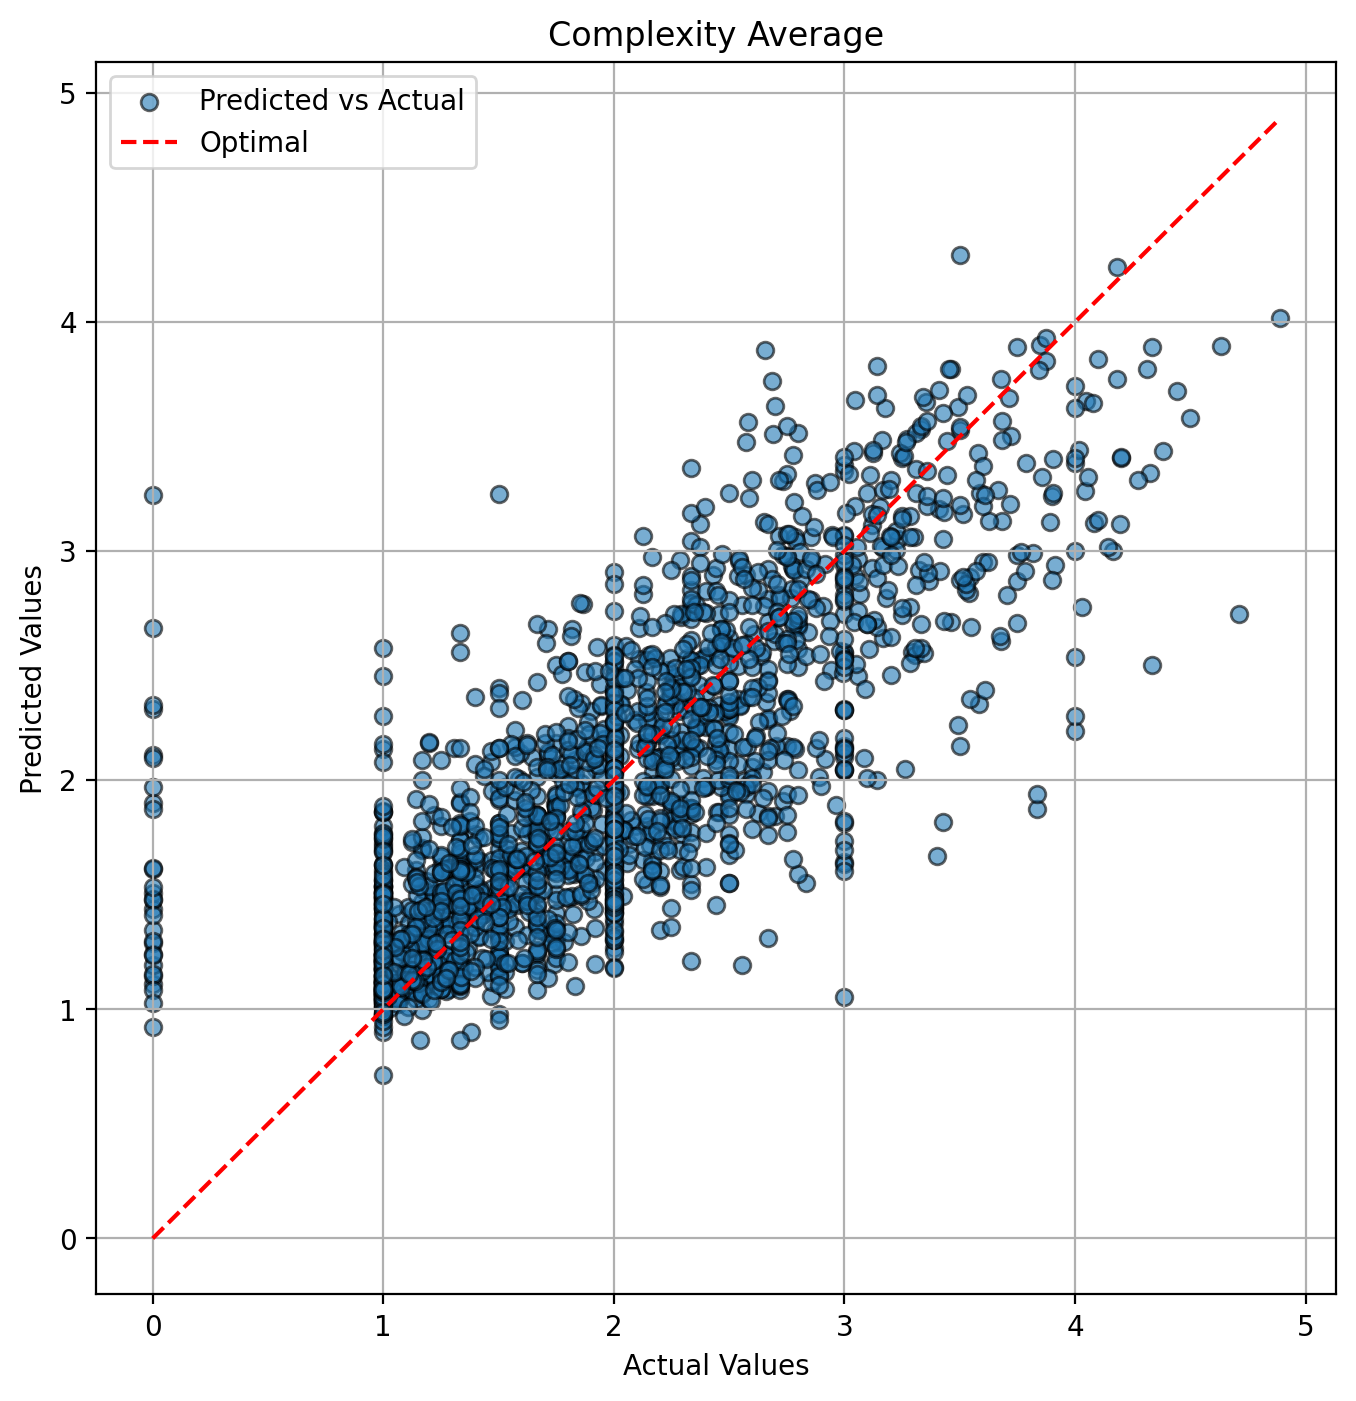

In [36]:
TARGET = "Complexity Average"
DATASET = 'original'
MODEL = 'Support Vector Regressor'


original_result = next((item for item in evaluation_results 
                        if item['Target'] == TARGET
                        and item["Dataset"] == DATASET 
                        and item["Model Name"] == MODEL
                        ), None)


X_train, X_test, y_train, y_test = train_test_split(
    datasets[DATASET],
    targets[TARGET],
    test_size=0.1,
    random_state=42)

svr_param_grid_v1 = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 1],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}
# Best parameters for SVR: {'C': 1, 'epsilon': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}

svr_param_grid_v2 = {
    'C': [0.5, 1, 2.5, 5],
    'epsilon': [0.05, 0.1, 0.25, 5],
    'kernel': ['rbf'],
    'gamma': ['auto']
}
# Best parameters for SVR: {'C': 2.5, 'epsilon': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}

svr_param_grid_v3 = {
    'C': np.arange(1, 5, 0.5),
    'epsilon': [0.1],
    'kernel': ['rbf'],
    'gamma': ['auto']
}
# Best parameters for SVR: {'C': 3.0, 'epsilon': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}

svr = SVR()
grid_search_svr = GridSearchCV(estimator=svr, 
                               param_grid=svr_param_grid_v3,
                               scoring='r2',
                               cv=3, 
                               verbose=2, 
                               n_jobs=-1)

_ = grid_search_svr.fit(X_train, y_train)

# Best parameters
print("Best parameters for SVR:", grid_search_svr.best_params_)

ca_svr_best_model = grid_search_svr.best_estimator_
evaluate_hypertuned_model(original_result, ca_svr_best_model, X_test, y_test)

#### 4.4.2 GradientBoostingRegressor - Popularity Score

In [37]:
def optimize_gradient_boosting(X_train, y_train, param_space):
    model = GradientBoostingRegressor()

    opt = BayesSearchCV(
        model,
        param_space,
        n_iter=50,
        cv=4,
        n_jobs=-1,
        verbose=0,
        random_state=42,
        scoring='r2'
    )

    _ = opt.fit(X_train, y_train)

    print("Best Hyperparameters:", "\n".join(f"{k}: {v}" for k, v in opt.best_params_.items()))

    return opt

Best Hyperparameters: learning_rate: 0.01913186344294423
max_depth: 7
min_samples_leaf: 5
min_samples_split: 25
n_estimators: 350
subsample: 0.4
Popularity ScoreEvaluation Results:
RMSE: 2.098 --> 2.063
MAE:  1.724 --> 1.675
R2:   0.400 --> 0.423


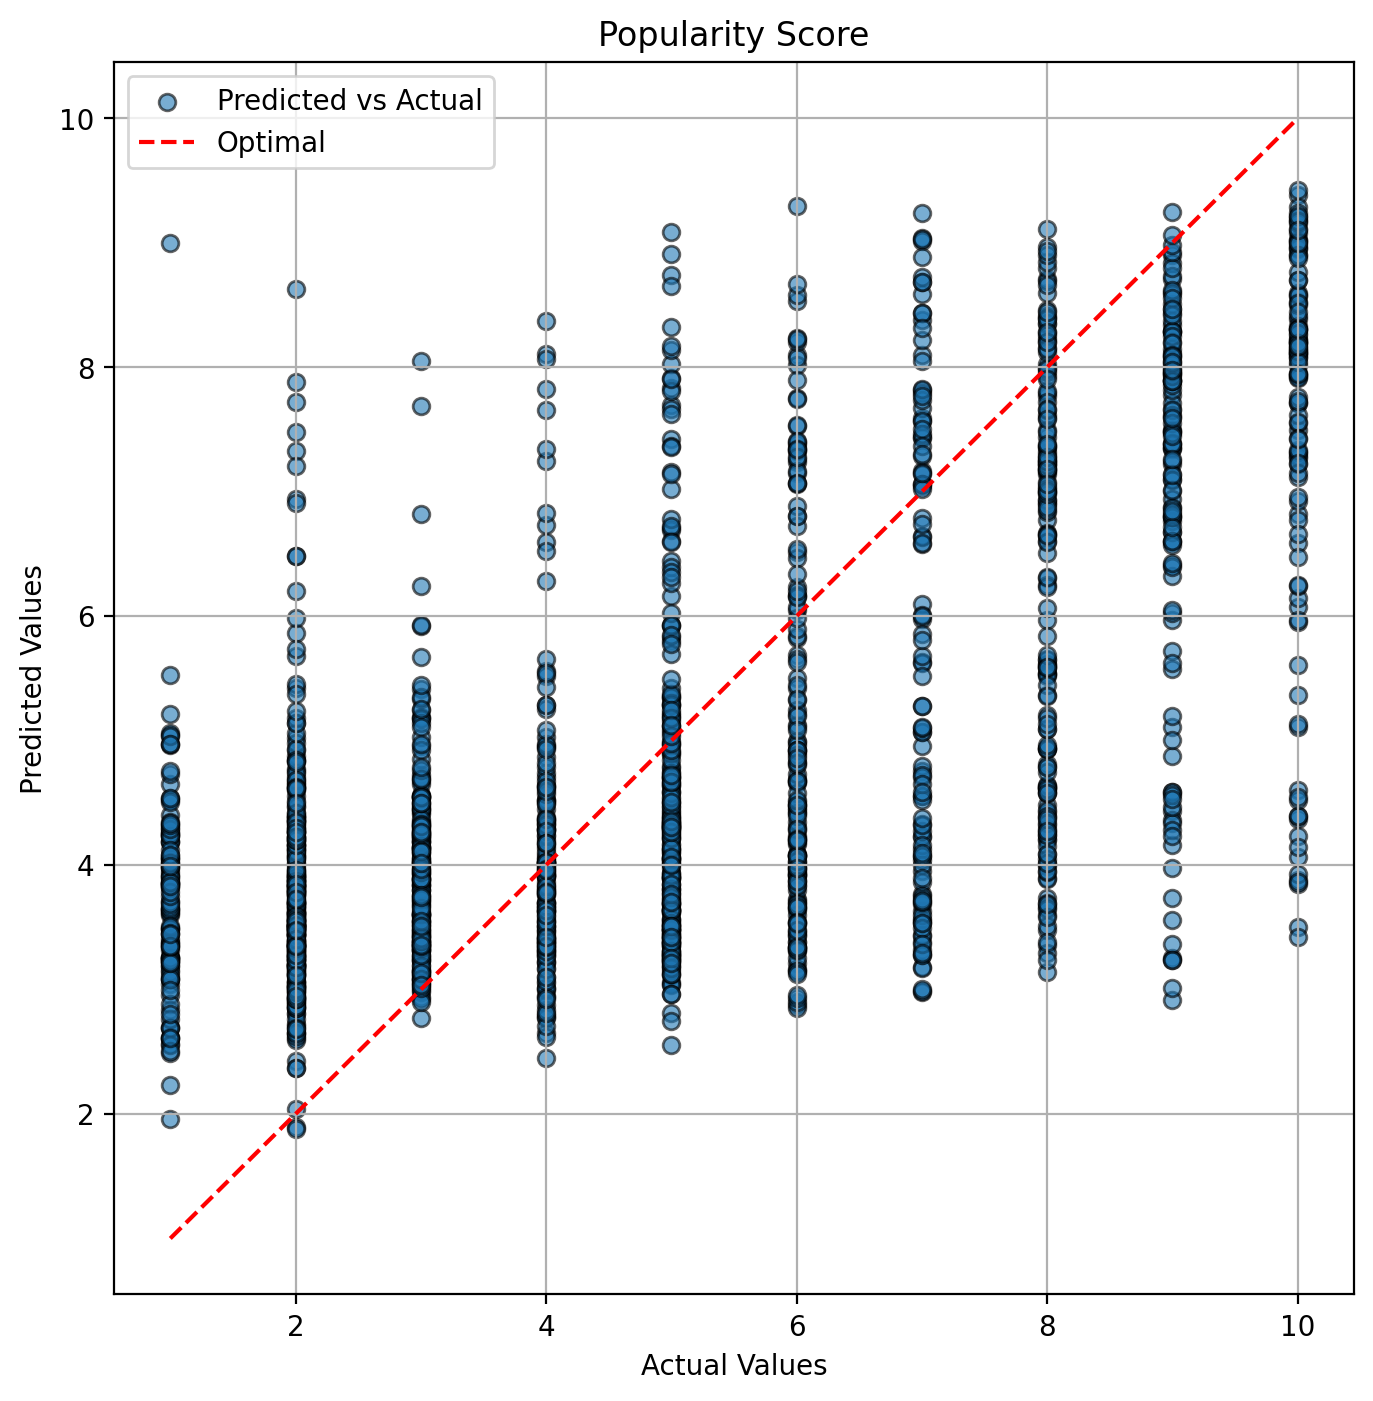

In [38]:
TARGET = "Popularity Score"
DATASET = 'original'
MODEL = 'GradientBoostingRegressor'

ps_original_result = next((item for item in evaluation_results
                        if item['Target'] == TARGET
                        and item["Dataset"] == DATASET
                        and item["Model Name"] == MODEL
                        ), None)


ps_X_train, ps_X_test, ps_y_train, ps_y_test = train_test_split(
    datasets[DATASET],
    targets[TARGET],
    test_size=0.1,
    random_state=42)

ps_params_v1 = {
    'learning_rate': (0.001, 0.1, 'uniform'),  
    'max_depth': (3, 10), # Maximum depth of the trees
    'min_samples_leaf': (1, 10), # Minimum number of samples required to be a leaf node
    'min_samples_split': (2, 10), # Minimum number of samples required to split a node
    'n_estimators': (50, 500),  # Number of trees
    'subsample': (0.5, 1.0), # Fraction of samples to use for fitting each tree
}
# Best Hyperparameters: 
#     learning_rate: 0.03416081279195174
#     max_depth: 5
#     min_samples_leaf: 10
#     min_samples_split: 10
#     n_estimators: 336
#     subsample: 0.5

ps_params_v2 = {
    'learning_rate': (0.01, 0.05, 'uniform'),
    'max_depth': (3, 7), # Maximum depth of the trees
    'min_samples_leaf': (9, 15), # Minimum number of samples required to be a leaf node
    'min_samples_split': (9, 15), # Minimum number of samples required to split a node
    'n_estimators': (250, 450),  # Number of trees
    'subsample': (0.2, 0.7), # Fraction of samples to use for fitting each tree
}
# Best Hyperparameters: 
    # learning_rate: 0.022416931570370745
    # max_depth: 7
    # min_samples_leaf: 9
    # min_samples_split: 15
    # n_estimators: 368
    # subsample: 0.7

ps_params_v3 = {
    'learning_rate': (0.015, 0.04, 'uniform'),
    'max_depth': (6, 12), # Maximum depth of the trees
    'min_samples_leaf': (7, 13), # Minimum number of samples required to be a leaf node
    'min_samples_split': (13, 20), # Minimum number of samples required to split a node
    'n_estimators': (300, 450),  # Number of trees
    'subsample': (0.6, 1.0), # Fraction of samples to use for fitting each tree
}
# Best Hyperparameters: 
#     learning_rate: 0.018371231938159545
#     max_depth: 6
#     min_samples_leaf: 7
#     min_samples_split: 20
#     n_estimators: 450
#     subsample: 0.6

ps_params_v4 = {
    'learning_rate': (0.015, 0.025, 'uniform'),
    'max_depth': (4, 8), # Maximum depth of the trees
    'min_samples_leaf': (5, 10), # Minimum number of samples required to be a leaf node
    'min_samples_split': (18, 25), # Minimum number of samples required to split a node
    'n_estimators': (350, 500),  # Number of trees
    'subsample': (0.4, 0.8), # Fraction of samples to use for fitting each tree
}


ps_gbr = optimize_gradient_boosting(ps_X_train, ps_y_train, ps_params_v4)
ps_bgr_best_model = ps_gbr.best_estimator_


evaluate_hypertuned_model(ps_original_result, ps_bgr_best_model, ps_X_test, ps_y_test)

#### 4.4.3 GradientBoostingRegressor - Rating Average

[CV] END .........C=1.5, epsilon=0.1, gamma=auto, kernel=rbf; total time=   5.0s
[CV] END .........C=3.5, epsilon=0.1, gamma=auto, kernel=rbf; total time=   5.2s
[CV] END .........C=2.5, epsilon=0.1, gamma=auto, kernel=rbf; total time=   5.1s
[CV] END .........C=3.5, epsilon=0.1, gamma=auto, kernel=rbf; total time=   5.3s
[CV] END .........C=1.5, epsilon=0.1, gamma=auto, kernel=rbf; total time=   4.9s
[CV] END .........C=3.0, epsilon=0.1, gamma=auto, kernel=rbf; total time=   5.2s
[CV] END .........C=4.5, epsilon=0.1, gamma=auto, kernel=rbf; total time=   4.4s
[CV] END .........C=2.0, epsilon=0.1, gamma=auto, kernel=rbf; total time=   5.1s
[CV] END .........C=3.5, epsilon=0.1, gamma=auto, kernel=rbf; total time=   5.1s
[CV] END .........C=1.0, epsilon=0.1, gamma=auto, kernel=rbf; total time=   4.8s
[CV] END .........C=3.0, epsilon=0.1, gamma=auto, kernel=rbf; total time=   5.3s
[CV] END .........C=4.5, epsilon=0.1, gamma=auto, kernel=rbf; total time=   4.5s
Best Hyperparameters: learni

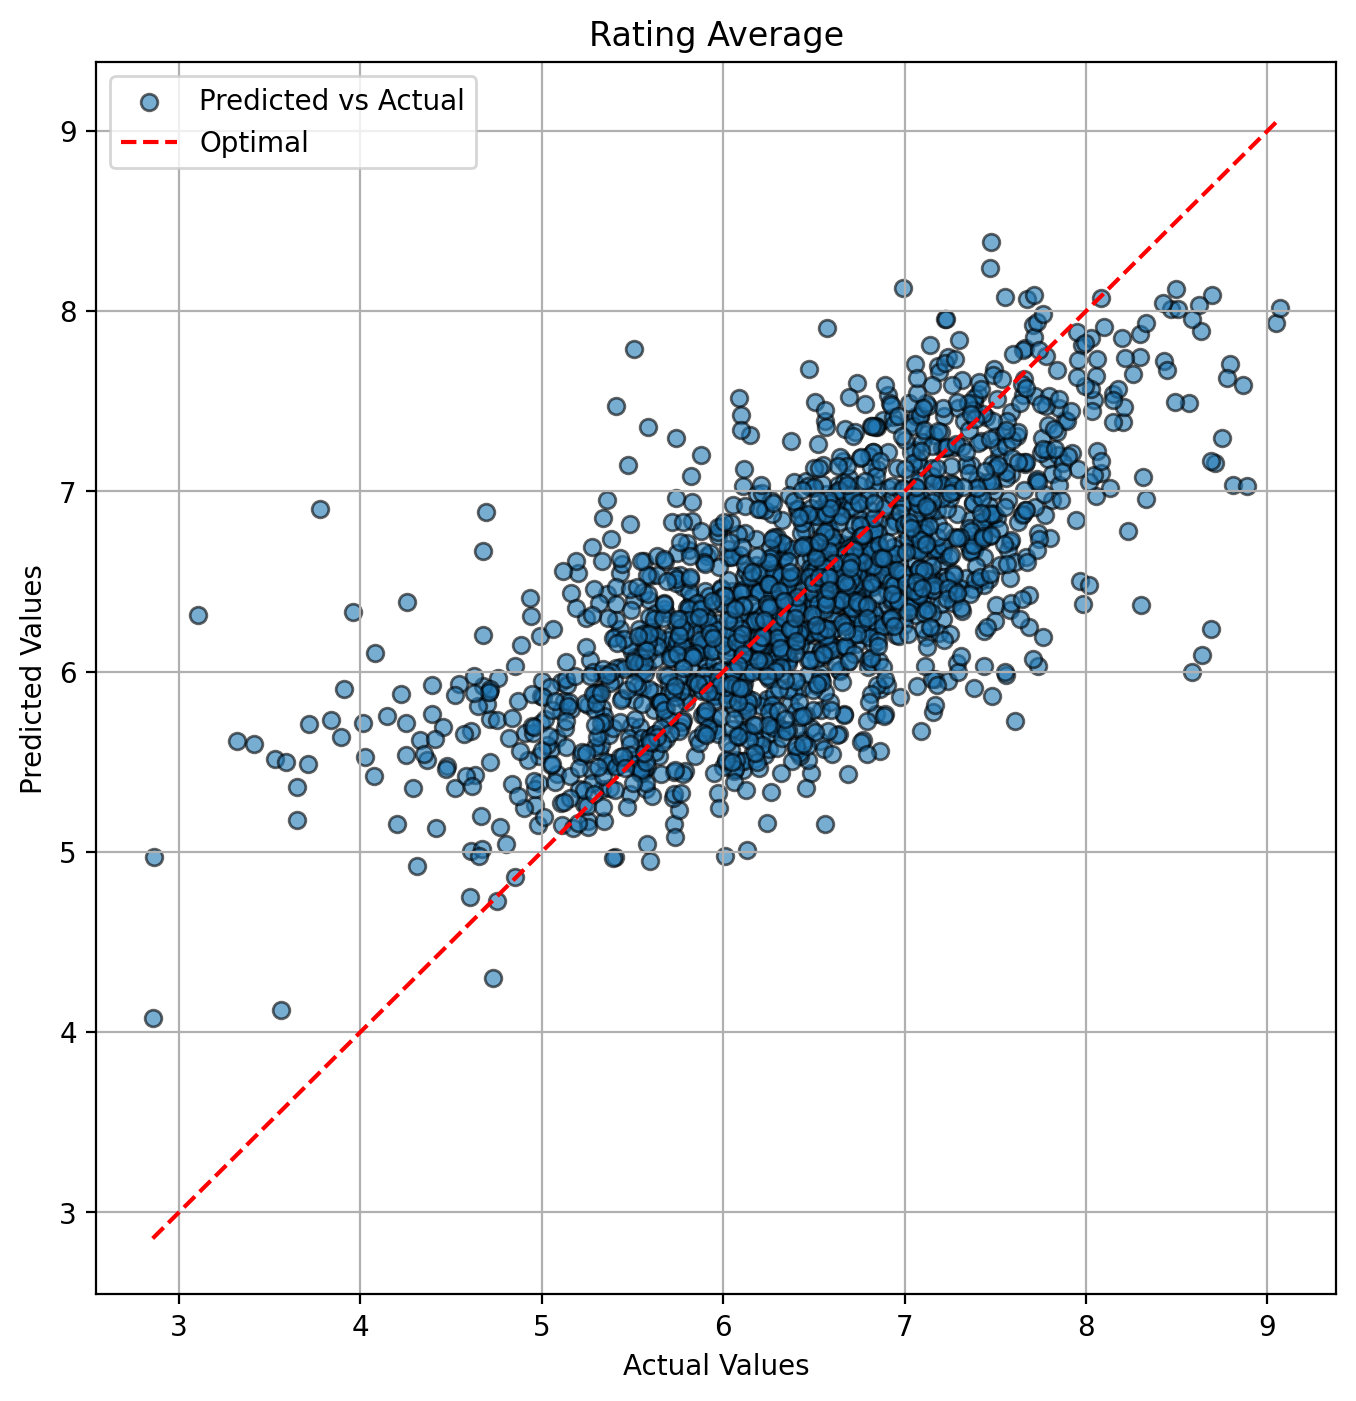

In [39]:
TARGET = "Rating Average"
DATASET = 'original'
MODEL = 'GradientBoostingRegressor'

ra_original_result = next((item for item in evaluation_results
                        if item['Target'] == TARGET
                        and item["Dataset"] == DATASET
                        and item["Model Name"] == MODEL
                        ), None)


ra_X_train, ra_X_test, ra_y_train, ra_y_test = train_test_split(
    datasets[DATASET],
    targets[TARGET],
    test_size=0.1,
    random_state=42)


ra_params_v1 = {
    'learning_rate': (0.001, 0.1, 'uniform'),
    'max_depth': (3, 10), # Maximum depth of the trees
    'min_samples_leaf': (1, 10), # Minimum number of samples required to be a leaf node
    'min_samples_split': (2, 10), # Minimum number of samples required to split a node
    'n_estimators': (50, 500),  # Number of trees
    'subsample': (0.5, 1.0), # Fraction of samples to use for fitting each tree
}
# Best Hyperparameters: 
    # learning_rate: 0.038388672315135174
    # max_depth: 7
    # min_samples_leaf: 10
    # min_samples_split: 10
    # n_estimators: 207
    # subsample: 0.5

ra_params_v2 = {
    'learning_rate': (0.01, 0.05, 'uniform'),
    'max_depth': (6, 9), # Maximum depth of the trees
    'min_samples_leaf': (9, 15), # Minimum number of samples required to be a leaf node
    'min_samples_split': (9, 15), # Minimum number of samples required to split a node
    'n_estimators': (125, 300),  # Number of trees
    'subsample': (0.2, 0.7), # Fraction of samples to use for fitting each tree
}
# Best Hyperparameters: 
    # learning_rate: 0.025373377818125778
    # max_depth: 7
    # min_samples_leaf: 9
    # min_samples_split: 15
    # n_estimators: 265
    # subsample: 0.7

ra_params_v3 = {
    'learning_rate': (0.015, 0.03, 'uniform'),
    'max_depth': (6, 8), # Maximum depth of the trees
    'min_samples_leaf': (7, 12), # Minimum number of samples required to be a leaf node
    'min_samples_split': (13, 20), # Minimum number of samples required to split a node
    'n_estimators': (200, 300),  # Number of trees
    'subsample': (0.6, 1.0), # Fraction of samples to use for fitting each tree
}
# Best Hyperparameters: 
#     learning_rate: 0.02235816773441548
#     max_depth: 7
#     min_samples_leaf: 8
#     min_samples_split: 18
#     n_estimators: 300
#     subsample: 0.6

ra_params_v4 = {
    'learning_rate': (0.015, 0.03, 'uniform'),
    'max_depth': (6, 8), # Maximum depth of the trees
    'min_samples_leaf': (7, 10), # Minimum number of samples required to be a leaf node
    'min_samples_split': (15, 20), # Minimum number of samples required to split a node
    'n_estimators': (250, 350),  # Number of trees
    'subsample': (0.4, 0.8), # Fraction of samples to use for fitting each tree
}


ra_gbr = optimize_gradient_boosting(ra_X_train, ra_y_train, ra_params_v4)
ra_bgr_best_model = ra_gbr.best_estimator_


evaluate_hypertuned_model(ra_original_result, ra_bgr_best_model, ra_X_test, ra_y_test)

## 5. Saving Models and Artifacts

In [40]:
# # Prep for dataset
# joblib.dump(mlbs['Domains'], "../artifacts/Domains_MLB.pkl")
# joblib.dump(mlbs['Clusters'], "../artifacts/Clusters_MLB.pkl")
# joblib.dump(scaler, "../artifacts/Scaler.pkl")
# 
# # Prediction Models
# joblib.dump(ca_svr_best_model, "../artifacts/Complexity_Average_Model.pkl")
# joblib.dump(ps_bgr_best_model, "../artifacts/Popularity_Score_Model.pkl")
# joblib.dump(ra_bgr_best_model, "../artifacts/Rating_Average_Model.pkl")
